#**Trabajo final Introducción a Machine Learning**
##Sofía Pérez Pérez

## **Parte 3**: Modelo final y predicción del test data

Importamos las librerías que se vayan a necesitar a lo largo de todo el proceso

In [ ]:
!pip install fastcore matplotlib pandas sklearn category_encoders shap seaborn xgboost

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import joblib
from fastcore.all import *
import wandb
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [7]:
! pip install category_encoders

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
# Estas opciones permiten mostrar el dataframe de pandas de manera completa
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [9]:
wandb.init(
    project=os.getenv("WANDB_PROJECT", "Fraud-classification"),
    name=os.getenv("WANDB_RUN_NAME", "baseline"),
    config={"model": "XGboost"})

wandb: Currently logged in as: sofiaperezperez22 (sofiaperezperez22-universidad-polit-cnica-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Leemos los datos del csv

In [10]:
datos = pd.read_csv('data_labels.csv', sep = ',')

In [11]:
test_data = pd.read_csv('data_labels.csv', sep = ',')



In [12]:
len(datos)

90009

### Desbalanceo de la target

In [13]:
TARGET  = 'label'

Para solucionar el desbalanceo, lo que hacemos es eliminar de manera aleatoria observaciones de la clase mayoritaria, en este caso transacciones que no acaban impagandose.

In [14]:
# Separar la clase mayoritaria y minoritaria
df_majority = datos[datos[TARGET] == 0]
df_minority = datos[datos[TARGET] == 1]

# Hacer downsampling de la clase mayoritaria
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Concatenar clase minoritaria con clase mayoritaria reducida
df_balanced = pd.concat([df_majority_downsampled, df_minority])

### Tratamiento variables categóricas

Eliminamos la variable ID porque no es una posible variable si no que es el identificador.
No queremos que el modelo aprenda a que una transacción se vaya a impagar en función de la persona que lo haga o el Id que tenga,
si no que se fije en las características de la transacción
Eliminamos también el "Expenditure_AHF" porque es una variable tipo fecha que tampoco creo que vaya ayudar a la predicción  

In [15]:
columnas_categoricas = df_balanced.select_dtypes(include = 'object').columns
columnas_categoricas = columnas_categoricas.drop(["ID", "Expenditure_AHF"])

In [16]:
columnas_entrenamiento = df_balanced.columns.drop(["ID", "Expenditure_AHF", "label"]) # Expenditure_AHF es la fecha de la transaccion

#### Usamos la técnica de target encoder

La técnica de target encoder lo que hace es que asigna el valor medio de la target para un valor concreto de cada variable categórica. Por ejemplo, en la variable categórica de Infraction_TEN, mirará cada posible valor de esa variable (moderate, high, low, etc), y los sustituirá por el valor medio que toma la target en esos casos. No obstante, para evitar overfitting, se ha elegido que solo se haga este procedicimento para aquellos valores que aparezcan en al menos 50 registros. Si no, se aplicará la media de la target global del dataset completo.

In [17]:
df_balanced['label'] = df_balanced['label'].astype('int')

In [18]:
from category_encoders import TargetEncoder

te_params_dict = {'min_samples_leaf': 50, 'smoothing': 1}
target_encoder = TargetEncoder(**te_params_dict)
df_balanced[[var + '_enc' for var in columnas_categoricas]] = target_encoder.fit_transform(df_balanced[columnas_categoricas], df_balanced[TARGET])
test_data[[var + '_enc' for var in columnas_categoricas]] = target_encoder.transform(test_data[columnas_categoricas])

In [19]:
test_data[[var + '_enc' for var in columnas_categoricas]] = target_encoder.transform(test_data[columnas_categoricas])

### Valores nulos

No obstante, vemos en detalle el % de nulos de cada variable

In [20]:
nulos = {}
for var in df_balanced.columns:
    nulos[var] = df_balanced[var].isna().sum()/len(df_balanced)*100

Decidimos borrar las variables que tengan un % de nulos mayor del 40%. Podríamos dejarlas e imputarlos de alguna manera, pero al tener tantos registros nulos, es posible que no captemos la verdadera distribución de esas variables y el proceso de aprendizaje no sea óptimo. El resto de variables con un % menor serán tratadas posteriormente con un KNN imputer.

In [21]:
porc_nulos_borrar = 40
# columnas a eliminar
nulos_borrar = dict(filter(lambda x: x[1] > porc_nulos_borrar, nulos.items()))

In [22]:
variables_borrar = nulos_borrar.keys()
# Eliminamos las columnas con un alto % de nulos
datos.drop(variables_borrar, axis = 1, inplace = True)
print(f"Hemos eliminado {len(variables_borrar)} variables")

Hemos eliminado 31 variables


#### Usamos imputer

In [23]:
columnas_numericas = df_balanced.select_dtypes(include = ['int64', 'float64']).columns

In [24]:
columnas_numericas = columnas_numericas.drop('label')

In [25]:
# Crear el imputador KNN con un número de vecinos (por ejemplo, k=2)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Puedes cambiar a 'median' o 'most_frequent'
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(df_balanced[columnas_numericas]),
    columns=columnas_numericas
)


In [26]:
test_data = pd.DataFrame(imputer.transform(test_data[columnas_numericas]), columns=[columnas_numericas])

## Separamos en train y test para entrenamiento

In [27]:
cols_datos = X_train_imputed.columns[X_train_imputed.columns != TARGET]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_imputed[cols_datos], df_balanced[TARGET], test_size=0.2, stratify=df_balanced[TARGET], random_state=42
)

## Seleccionamos las columnas de entrenamiento

In [29]:
columnas_train = list(set(['Infraction_SBF','Infraction_JVWF','Infraction_HPLO','Infraction_QGC','Infraction_EBA','Base_64022','Infraction_SVKR',
                  'Infraction_MAN','Infraction_WWLN', 'Infraction_ADWZ', 'Payment_6804','Base_80863','Infraction_TLPJ','Base_85131',
                  'Infraction_BSU','Infraction_ZYW','Infraction_TBP','Base_69608','Base_9103','Base_67254_enc',  'Payment_6804', 'Base_7744',
                  'Base_80863', 'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683', 'Infraction_SBF', 'Infraction_ZWWJ', 'Infraction_QJJF',
                  'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Infraction_FMXQ', 'Infraction_GGO', 'Infraction_TLPJ', 'Infraction_NCB', 'Base_1165',
                  'Base_39598', 'Base_6187', 'Infraction_CLLY', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516',
                  'Infraction_GWL', 'Expenditure_YTR', 'Base_36384', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_BSU', 'Infraction_GEL',
                  'Base_14808', 'Infraction_ZYW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Infraction_PBC', 'Base_0229', 'Base_8318',
                  'Base_69608', 'Base_91828', 'Base_6852', 'Base_22178', 'Infraction_ZTYG', 'Infraction_ZVW', 'Base_3041', 'Infraction_JVWF', 'Payment_3207',
                  'Infraction_QKZN', 'Infraction_CZE', 'Infraction_APIU', 'Infraction_JBR', 'Base_66195', 'Infraction_RXQH', 'Risk_5797', 'Base_67585',
                  'Infraction_WEG', 'Base_9103', 'Expenditure_UIWS', 'Expenditure_ONEG', 'Expenditure_MTRQ', 'Expenditure_LAHK', 'Infraction_ETH',
                  'Infraction_ZVHJ', 'Infraction_ANHZ', 'Base_2810', 'Risk_4561', 'Risk_8902', 'Infraction_HPLO', 'Infraction_QGC', 'Infraction_EBA',
                  'Base_64022', 'Infraction_BGGU', 'Base_4569', 'Infraction_LMHK', 'Infraction_TPAF', 'Infraction_XEPQ', 'Infraction_ZMKI', 'Infraction_RKTA',
                  'Infraction_IIZ', 'Infraction_KEJT', 'Infraction_QEY', 'Base_3958', 'Infraction_WLMI', 'Infraction_SVKR', 'Infraction_MAN', 'Infraction_WWLN',
                  'Infraction_ZTLC', 'Base_67254_enc', 'Payment_6804', 'Base_7744', 'Base_80863', 'Expenditure_JIG', 'Base_02683', 'Infraction_SBF',
                  'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065', 'Infraction_EJZ', 'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_6187', 'Base_85131',
                  'Infraction_AYWV', 'Base_9516', 'Base_36384', 'Expenditure_HMO', 'Infraction_BSU', 'Infraction_TBP', 'Infraction_PBC', 'Base_8318', 'Base_69608',
                  'Base_6852', 'Base_3041', 'Infraction_CZE', 'Infraction_APIU', 'Infraction_JBR', 'Infraction_WEG', 'Base_9103', 'Base_2810', 'Risk_4561',
                  'Risk_8902', 'Infraction_QGC', 'Base_4569', 'Base_3958','Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863', 'Risk_1930',
                  'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683', 'Infraction_SBF', 'Infraction_ZWWJ', 'Base_76065', 'Base_6872', 'Infraction_FMXQ',
                  'Infraction_GGO', 'Infraction_TLPJ', 'Base_39598', 'Base_6187', 'Infraction_CLLY', 'Infraction_ZTNC', 'Risk_9995', 'Payment_22507',
                  'Infraction_GWL', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_GEL',
                  'Base_14808', 'Risk_8065', 'Infraction_ZYW', 'Expenditure_KMW', 'Base_1039', 'Infraction_HSSU', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD',
                  'Infraction_PBC', 'Base_69608', 'Base_91828', 'Infraction_HPS', 'Base_6852', 'Expenditure_BWX', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG',
                  'Base_3041', 'Infraction_JVWF', 'Infraction_QKZN', 'Infraction_CZE', 'Infraction_APIU', 'Infraction_JBR', 'Base_66195', 'Risk_5797',
                  'Expenditure_HRQ', 'Infraction_VTR', 'Risk_4804', 'Base_67585', 'Risk_4247', 'Risk_0454', 'Base_8379', 'Infraction_WEG', 'Base_9103',
                  'Infraction_KSBR', 'Infraction_WVC', 'Risk_8532', 'Infraction_IMIM', 'Expenditure_UIWS', 'Expenditure_MTRQ', 'Infraction_ETH', 'Base_2810',
                  'Risk_4561', 'Risk_8902', 'Infraction_QGC', 'Infraction_EBA', 'Base_64022', 'Infraction_BGGU', 'Base_4569', 'Infraction_NMCB', 'Infraction_XEPQ',
                  'Infraction_ZMKI', 'Infraction_RKTA', 'Infraction_KEJT', 'Infraction_WMAQ', 'Base_3958', 'Infraction_VHHP', 'Infraction_WLMI', 'Infraction_LIES',
                  'Infraction_QWWW', 'Infraction_QGR', 'Infraction_LSX', 'Base_67254_enc', 'Infraction_TEN_enc']))


In [30]:
print(f"Hay {len(columnas_train)} columnas de entrenamiento")

Hay 123 columnas de entrenamiento


## Entrenamos el modelo

In [32]:
best_params_gb = {'colsample_bytree':0.7426112300589203,
'learning_rate':0.24950785363900532,
'max_depth':7,
'n_estimators':200,
'subsample':0.9404357846919617}

# Crear el modelo XGBClassifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model = xgb.XGBClassifier(
    **best_params_gb,       # Tasa de aprendizaje
    use_label_encoder=False,
    eval_metric='mlogloss'
)
# Tenemos que modificar la target porque XGBoost solo trabaja con valores de 0, 1 en la target
# Y nuestra target original tomaba valores de -1 y 1.
y_train_modified = np.where(y_train == -1, 0, y_train)
y_test_modified = np.where(y_test == -1, 0, y_test)
# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train[columnas_train], y_train_modified)

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test[columnas_train])

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test_modified, y_pred)
print(f'AUC del modelo: {accuracy:.4f}')
print(f'Matriz de confusion: {confusion_matrix(y_test_modified, y_pred)}')

c:\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC del modelo: 0.9425
Matriz de confusion: [[5525  476]
 [ 214 5787]]



Top 20 variables más importantes según SHAP:
             feature  importance
38      Payment_6804    1.142610
53    Infraction_EJZ    0.315103
122       Base_76065    0.274320
0     Infraction_GGO    0.271449
71   Infraction_TLPJ    0.269890
101  Infraction_RKTA    0.248876
73    Infraction_CZE    0.245176
112       Base_02683    0.230807
108   Infraction_BSU    0.207591
31   Infraction_FMXQ    0.207177
115   Infraction_TBP    0.195766
14   Expenditure_JIG    0.193733
26         Base_7744    0.186821
66         Risk_8902    0.179421
113  Infraction_AYWV    0.159296


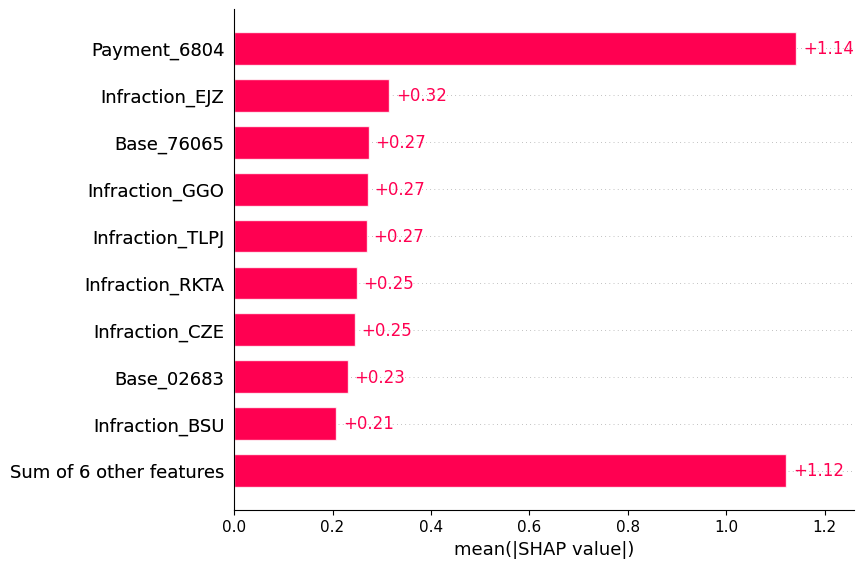

In [33]:
import shap

explainer = shap.Explainer(model)

# Calcular valores SHAP para el set de entrenamiento
shap_values = explainer(X_train[columnas_train])

# Importancia media absoluta
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Asociar cada valor a su columna
importance_df = pd.DataFrame({
    'feature': columnas_train,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)

# Mostrar top 15 variables
top_20 = importance_df.head(15)
print("\nTop 20 variables más importantes según SHAP:")
print(top_20)

# =========================
# Gráfico resumen SHAP
# =========================
shap.plots.bar(shap_values[:, top_20['feature'].values])

In [39]:
import wandb
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Simula tus datos o carga los reales aquí
from sklearn.datasets import make_classification

def train():
    wandb.init()
    config = wandb.config

    # Modelo con hiperparámetros desde wandb
    model = XGBClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(X_train[columnas_train], y_train_modified)
    y_pred = model.predict(X_test[columnas_train])
    y_proba = model.predict_proba(X_test[columnas_train])

    # Métricas
    acc = accuracy_score(y_test_modified, y_pred)
    precision = precision_score(y_test_modified, y_pred)
    recall = recall_score(y_test_modified, y_pred)
    f1 = f1_score(y_test_modified, y_pred)
    auc = roc_auc_score(y_test_modified, y_proba[:, 1])

    wandb.log({
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    })

    # Matriz de confusión
    cm = confusion_matrix(y_test_modified, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    wandb.log({"confusion_matrix": wandb.Image(fig)})
    plt.close(fig)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test_modified, y_proba[:, 1])
    wandb.log({
        "roc_curve": wandb.plot.line_series(
            xs=fpr,
            ys=[tpr],
            keys=["TPR"],
            title="ROC Curve",
            xname="FPR"
        )
    })

    # Tabla de predicciones
    table = pd.DataFrame({
        "true_label": y_test_modified,
        "predicted_label": y_pred,
        "probability": y_proba[:, 1]
    })
    wandb.log({"predictions_table": wandb.Table(dataframe=table)})

# Sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'auc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {'values': [100, 200, 300]},
        'learning_rate': {'min': 0.01, 'max': 0.3},
        'max_depth': {'values': [3, 5, 7]},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0}
    }
}

# Ejecutar sweep (solo la primera vez para crear ID)
sweep_id = wandb.sweep(sweep_config, project="Fraud-classification")

# Lanzar agente (corre varias pruebas automáticamente)
wandb.agent(sweep_id, function=train, count=10)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: rx64mbvc
Sweep URL: https://wandb.ai/sofiaperezperez22-universidad-polit-cnica-de-madrid/Fraud-classification/sweeps/rx64mbvc


wandb: Agent Starting Run: nmh8tmdu with config:
wandb: 	colsample_bytree: 0.5698982144868683
wandb: 	learning_rate: 0.09459712241950977
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	subsample: 0.914351775457788


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.87344
auc,0.94157
f1_score,0.87773
precision,0.84896
recall,0.90852


wandb: Agent Starting Run: hae7hpzf with config:
wandb: 	colsample_bytree: 0.7925992387188434
wandb: 	learning_rate: 0.2694114019095712
wandb: 	max_depth: 5
wandb: 	n_estimators: 200
wandb: 	subsample: 0.7779721767807994


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.91768
auc,0.97096
f1_score,0.91956
precision,0.89906
recall,0.94101


wandb: Agent Starting Run: ujacznvt with config:
wandb: 	colsample_bytree: 0.7426112300589203
wandb: 	learning_rate: 0.24950785363900532
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	subsample: 0.9404357846919617


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.93793
auc,0.98322
f1_score,0.93935
precision,0.91834
recall,0.96134


wandb: Agent Starting Run: fnktqk6i with config:
wandb: 	colsample_bytree: 0.6029684980514997
wandb: 	learning_rate: 0.149265441528333
wandb: 	max_depth: 5
wandb: 	n_estimators: 300
wandb: 	subsample: 0.8394734454130641


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.91793
auc,0.97164
f1_score,0.92007
precision,0.89671
recall,0.94468


wandb: Agent Starting Run: kvs30531 with config:
wandb: 	colsample_bytree: 0.6366693657135929
wandb: 	learning_rate: 0.036361700870024355
wandb: 	max_depth: 7
wandb: 	n_estimators: 100
wandb: 	subsample: 0.6908714929992088


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.88677
auc,0.95401
f1_score,0.89101
precision,0.85884
recall,0.92568


wandb: Agent Starting Run: drjhub7j with config:
wandb: 	colsample_bytree: 0.6406634163843701
wandb: 	learning_rate: 0.13742547747962144
wandb: 	max_depth: 5
wandb: 	n_estimators: 300
wandb: 	subsample: 0.6228930390833805


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.91185
auc,0.97008
f1_score,0.91407
precision,0.89162
recall,0.93768


wandb: Agent Starting Run: l22ssci6 with config:
wandb: 	colsample_bytree: 0.6064032504573691
wandb: 	learning_rate: 0.1542824958696834
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	subsample: 0.8130478306383446


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.89485
auc,0.95857
f1_score,0.8977
precision,0.87403
recall,0.92268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ywjixe5 with config:
wandb: 	colsample_bytree: 0.8310898394305894
wandb: 	learning_rate: 0.22472256968476836
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	subsample: 0.7897597925484643


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.88385
auc,0.9492
f1_score,0.88727
precision,0.8619
recall,0.91418


wandb: Agent Starting Run: wfd8q9e3 with config:
wandb: 	colsample_bytree: 0.920783241729449
wandb: 	learning_rate: 0.12168561063375095
wandb: 	max_depth: 7
wandb: 	n_estimators: 100
wandb: 	subsample: 0.6866544692955805


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.91093
auc,0.96927
f1_score,0.9136
precision,0.88701
recall,0.94184


wandb: Agent Starting Run: xw0tgwl3 with config:
wandb: 	colsample_bytree: 0.6627554801435929
wandb: 	learning_rate: 0.049427056385369865
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	subsample: 0.7827104286493536


wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.90785
auc,0.96831
f1_score,0.91062
precision,0.88404
recall,0.93884


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x00000284CEDE5780>> (for post_run_cell), with arguments args (<ExecutionResult object at 284f49661d0, execution_count=40 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 284f4966140, raw_cell="# Simula tus datos o carga los reales aquí
from sk.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/javier/OneDrive/Documentos/Master/MLOps/upm-dl-mlops/project/notebooks/best_model.ipynb#Y124sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] Se ha anulado una conexión establecida por el software en su equipo host

In [68]:
test_data['predicciones'] = model.predict(test_data[columnas_train])

In [69]:
test_data['predicciones'].value_counts()

,count
predicciones,
0,40263
1,20044
